In [1]:
from pyspark.ml.classification import LinearSVC


In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/11 17:22:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/03/11 17:22:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
data = spark.read.csv("creditcard_hugefraud.csv", header=True, inferSchema=True)
data.show(4)
from pyspark.sql.functions import abs, col
from pyspark.sql import functions as fn

# calculate the minimum value for each column
min_vals = data.agg(*[fn.min(c).alias(c) for c in data.columns])

# get the absolute minimum value from the DataFrame
abs_min = min_vals.select([fn.abs(fn.col(c)).alias(c) for c in min_vals.columns]).first()

included_cols = [c for c in data.columns if c not in ['Amount', 'Class']]
#df_shifted = data.select([col(c) + abs_min[c] for c in included_cols],col('Amount'), col('Class'))
#df_shifted = data.select([col(c) + abs_min[c] for c in included_cols])
df_shifted = data.select(
     *[(col(c) + abs_min[c]).alias(c) if c in included_cols else col(c).alias(c) for c in data.columns]
 )


# shift the data to make all values non-negative
#df_shifted = data.select([col(c) + abs_min[c] for c in data.columns])
df_shifted.show(4)

23/03/11 17:22:50 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+----+------------+------------+-----------+------------+------------+------------+------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------+-----+
|Time|         PC1|         PC2|        PC3|         PC4|         PC5|         PC6|         PC7|        PC8|         PC9|        PC10|        PC11|        PC12|        PC13|        PC14|        PC15|        PC16|        PC17|        PC18|        PC19|        PC20|        PC21|        PC22|        PC23|        PC24|        PC25|        PC26|        PC27|        PC28|Amount|Class|
+----+------------+------------+-----------+------------

+----+------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------+-----------+------------+------------------+------------------+------------------+------------+------------------+------------------+------------------+------------------+------------+------------------+------------+------------------+------+-----+
|Time|         PC1|              PC2|               PC3|               PC4|               PC5|               PC6|               PC7|              PC8|               PC9|              PC10|             PC11|              PC12|              PC13|        PC14|       PC15|        PC16|              PC17|              PC18|              PC19|        PC20|              PC21|              PC22|              PC23|              PC24|        PC25|              PC26|        PC27|              PC28|Am

In [4]:
# Prepare data for training
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=["PC1", "PC2","PC3","PC4", "PC5","PC6","PC7", "PC8","PC9","PC11", "PC11","PC12","PC13","PC14", "PC15","PC16","PC17", "PC18","PC19","PC20","PC21","Amount"], outputCol="features")
data_1 = assembler.transform(df_shifted).select("Class", "features")


In [5]:
data_1.show(2,False)
data2=data_1.withColumnRenamed("Class","label")
data2.show(2,False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Class|features                                                                                                                                                                                                                                                                                                                               |
+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
(trainingData, testData) = data2.randomSplit([0.7, 0.3])
from pyspark.ml.classification import LinearSVC
# Create a LinearSVC instance with a regularization parameter of 0.1
svc = LinearSVC(regParam=0.1)

import time

# start time
start_time = time.time()

# Fit the model to your data
model_LSVC = svc.fit(trainingData)

# end time
end_time = time.time()

# calculate the difference between start and end times in seconds
duration = end_time - start_time

# display the results
print(f"Start time: {start_time}")
print(f"End time: {end_time}")
print(f"Duration: {duration} seconds")


23/03/11 17:22:55 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/03/11 17:22:55 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Start time: 1678555372.718918
End time: 1678555387.7691917
Duration: 15.050273656845093 seconds


In [7]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Make predictions on the test data
predictions_LSVC = model_LSVC.transform(testData)

# Evaluate the accuracy of the model using the MulticlassClassificationEvaluator
evaluator_LSVC = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy_LSVC = evaluator_LSVC.evaluate(predictions_LSVC)

# Print the accuracy of the model
print("Accuracy LinearSVC:", accuracy_LSVC)

Accuracy LinearSVC: 0.6993507477474327


In [8]:
# get the number of available executors
num_executors = spark.sparkContext._jsc.sc().getExecutorMemoryStatus().size()

# display the number of available executors
print(f"Number of available executors: {num_executors}")

Number of available executors: 1


In [9]:
# Create a confusion matrix
from pyspark.sql.functions import col

confusion_matrix_LVSC = predictions_LSVC.groupBy("label", "prediction") \
    .count() \
    .orderBy(["label", "prediction"]) \
    .select("label", "prediction", col("count").alias("frequency"))

# Display the confusion matrix
confusion_matrix_LVSC.show()

+-----+----------+---------+
|label|prediction|frequency|
+-----+----------+---------+
|    0|       0.0|    59998|
|    1|       0.0|    25793|
+-----+----------+---------+



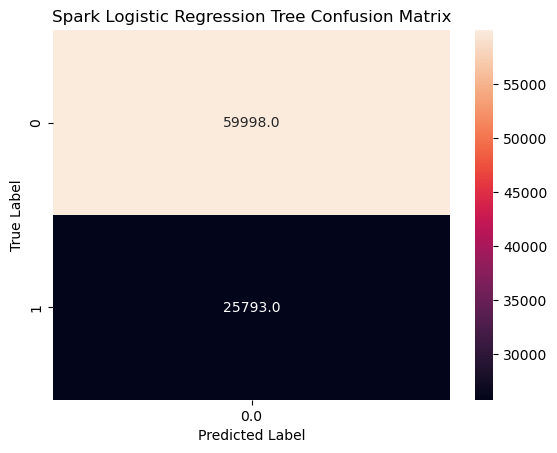

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
# Convert the confusion matrix to a Pandas DataFrame
pandas_df = confusion_matrix_LVSC.toPandas()

# Create a pivot table to reshape the data for plotting
pivot = pandas_df.pivot(index="label", columns="prediction", values="frequency")

# Create a heatmap plot of the confusion matrix
#sns.heatmap(pivot, annot=True, fmt="d")
sns.heatmap(pivot, annot=True, fmt=".1f")

# Set the plot title and axis labels
plt.title("Spark Logistic Regression Tree Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()

In [11]:
# Compute the precision for class 0
tp = predictions_LSVC.filter("label = 0 and prediction = 0").count()
fp = predictions_LSVC.filter("label = 1 and prediction = 0").count()
precision_0 = tp / (tp + fp)
print("Precision for class 0 = %g" % precision_0)

# Compute the precision for class 1
tp = predictions_LSVC.filter("label = 1 and prediction = 1").count()
fp = predictions_LSVC.filter("label = 0 and prediction = 1").count()
precision_1 = tp / (tp + fp)
print("Precision for class 1 = %g" % precision_1)

Precision for class 0 = 0.699351


ZeroDivisionError: division by zero